# Single Table Analysis Template

In [ ]:
# Removes lint errors from VS Code
from typing import Dict, TYPE_CHECKING, Tuple, List

if TYPE_CHECKING:
    import kedro

    catalog: kedro.io.data_catalog.DataCatalog
    session: kedro.framework.session.session.KedroSession
    pipelines: Dict[str, kedro.pipeline.pipeline.Pipeline]

In [ ]:
import os

VIEW = os.getenv("DATASET_VIEW") or "tab_adult"
TABLE = os.getenv("DATASET_TABLE") or "table"
ALG = os.getenv("SYNTH_ALG") or "privbayes"

import numpy as np
import pandas as pd

wrk: pd.DataFrame = catalog.load(f"{VIEW}.wrk.{TABLE}")
alg: pd.DataFrame = catalog.load(f"{VIEW}.{ALG}.{TABLE}")

from pasteur.metadata import Metadata
meta = catalog.load(f"params:{VIEW}.metadata")
meta = Metadata(meta, wrk).get_table(TABLE)

random_state = catalog.load("params:random_state")

In [ ]:
wrk.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
id,,,,,,,,,,,,,,
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States
10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States


In [ ]:
wrk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13024 entries, 4 to 32555
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             13024 non-null  int32   
 1   workclass       13024 non-null  category
 2   fnlwgt          13024 non-null  int32   
 3   education       13024 non-null  category
 4   education-num   13024 non-null  int32   
 5   marital-status  13024 non-null  category
 6   occupation      13024 non-null  category
 7   relationship    13024 non-null  category
 8   race            13024 non-null  category
 9   sex             13024 non-null  category
 10  capital-gain    13024 non-null  int32   
 11  capital-loss    13024 non-null  int32   
 12  hours-per-week  13024 non-null  int32   
 13  native-country  13024 non-null  category
dtypes: category(8), int32(6)
memory usage: 512.7 KB


In [ ]:
# Plotting
%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

plt.style.use("./utils/light.mplstyle")
plt.rcParams['figure.figsize'] = [9, 6]
# plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [ ]:
from pandas.api.types import (
    is_datetime64_any_dtype as is_datetime,
    is_timedelta64_dtype as is_timedelta,
)

def gen_freq(a, b, cols, is_cat=None, fillna=1e-6, bins=32):
    if isinstance(cols, str):
        cols = [cols]
    if isinstance(is_cat, bool):
        is_cat = [is_cat]

    # Shallow copy a, b and only keep cols
    # FIXME: stop dropping NAs
    a, b = a[cols].dropna(), b[cols].dropna()

    # Convert any continuous variables to discrete
    if is_cat is not None and not all(is_cat):
        for col, cat in zip(cols, is_cat):
            if cat:
                continue

            if is_datetime(a[col]):
                c, d = a[col].dt.day_of_year, b[col].dt.day_of_year
            else:
                c, d = pd.to_numeric(a[col]), pd.to_numeric(b[col])

            col_bins = np.histogram_bin_edges(c, bins=bins).astype(np.float32)
            a[col] = np.digitize(c, col_bins)
            b[col] = np.digitize(d, col_bins)

    ## Calculate frequencies of discrete variables
    a, b = a.value_counts(), b.value_counts()
    c = pd.concat([a, b], axis=1)
    c = c / c.sum()
    c = c.fillna(value=fillna)
    c[c == 0] = fillna
    c = c / c.sum()
    return c.iloc[:, 0], c.iloc[:, 1]


In [ ]:
from scipy.stats import chisquare

res = []
for col in meta.columns:
    k, j = gen_freq(wrk, alg, col, meta[col].is_cat())
    chi, p = chisquare(k, j)
    # print(f"{name:12}.{col:20}: X^2={chi:3.3f} p={100*p:7.3f}%")
    res.append([meta[col].type, col, chi, p])

res = pd.DataFrame(res, columns=["type", "col", "X^2", "p"])
res.set_index(keys=["type", "col"]).sort_index().style.background_gradient(axis=0)


X^2 
 p 
 
 
 type 
 col 
   
   
 
 
 
 
 categorical 
 education 
 0.001298 
 1.000000 
 
 
 marital-status 
 0.001286 
 1.000000 
 
 
 native-country 
 0.018741 
 1.000000 
 
 
 occupation 
 0.000796 
 1.000000 
 
 
 race 
 0.000721 
 1.000000 
 
 
 relationship 
 0.000098 
 1.000000 
 
 
 sex 
 0.000006 
 0.998040 
 
 
 workclass 
 0.000385 
 1.000000 
 
 
 numerical 
 age 
 0.008249 
 1.000000 
 
 
 capital-gain 
 0.000759 
 1.000000 
 
 
 capital-loss 
 0.035733 
 1.000000 
 
 
 education-num 
 0.002817 
 1.000000 
 
 
 fnlwgt 
 0.012562 
 1.000000 
 
 
 hours-per-week 
 0.009366 
 1.000000

In [ ]:
from scipy.stats import ks_2samp

res = []
for col in meta.cols:
    if meta[col].is_cat():
        continue
    c, d = wrk[col].dropna(), alg[col].dropna()
    ks, p = ks_2samp(c, d)
    res.append([meta[col].type, col, ks, p])

res = pd.DataFrame(res, columns=["type", "col", "K-S", "p"])
res.set_index(keys=["type", "col"]).style.background_gradient(axis=0)


K-S 
 p 
 
 
 type 
 col 
   
   
 
 
 
 
 numerical 
 age 
 0.085611 
 0.000000 
 
 
 fnlwgt 
 0.212224 
 0.000000 
 
 
 education-num 
 0.315418 
 0.000000 
 
 
 capital-gain 
 0.022190 
 0.003231 
 
 
 capital-loss 
 0.012592 
 0.250988 
 
 
 hours-per-week 
 0.489327 
 0.000000

In [ ]:
from scipy.special import rel_entr

res = []
cols = meta.cols
for i, col_i in enumerate(cols):
    if meta[col_i].is_id():
        continue
    cat_i = meta[col_i].is_cat()

    for col_j in cols: #[i + 1 :]:
        if meta[col_j].is_id():
            continue
        cat_j = meta[col_j].is_cat()

        if col_i == col_j:
            k, j = gen_freq(wrk, alg, [col_i], [cat_i])
        else:
            k, j = gen_freq(wrk, alg, [col_i, col_j], [cat_i, cat_j])
            
        kl = rel_entr(k, j).sum()
        kl_norm = 1 / (1 + kl)
        res.append([meta[col_i].type, col_i, meta[col_j].type, col_j, kl, kl_norm, len(k), cat_i, cat_j])

res = pd.DataFrame(
    res,
    columns=[
        "type_i",
        "col_i",
        "type_j",
        "col_j",
        "kl",
        "kl_norm",
        "mlen",
        "cat_i",
        "cat_j",
    ],
)
res.head()

,type_i,col_i,type_j,col_j,kl,kl_norm,mlen,cat_i,cat_j
0,numerical,age,numerical,age,0.001441,0.998561,32,False,False
1,numerical,age,categorical,workclass,0.083540,0.922901,217,False,True
2,numerical,age,numerical,fnlwgt,0.051377,0.951133,440,False,False
3,numerical,age,categorical,education,0.140680,0.876670,457,False,True
4,numerical,age,numerical,education-num,0.143264,0.874688,453,False,False


In [ ]:
def mk_kl_plot(filter=None, val="kl_norm"):
    # idx_tuples = []
    # for table in reversed(tables):
    #     a, _ = tables[table]
    #     for col in sorted(a.keys()):
    #         if is_categorical(table, col):
    #             idx_tuples.append((table, col))

    # idx = pd.MultiIndex.from_tuples(idx_tuples, names=['table_i', 'col_i'])
    # cols = pd.MultiIndex.from_tuples(reversed(idx_tuples), names=['table_j', 'col_j'])

    pt = res[filter] if filter is not None else res
    pt = pt.pivot_table(
        values=val, index=["type_i", "col_i"], columns=["type_j", "col_j"]
    )

    # Try to tweak colormap
    vmin = vmax = None
    # match val:
    #     case "kl_norm":
    #         vmin = 0.996
    #     case "kl":
    #         vmax = 0.04
    #     case "mlen":
    #         vmax = 100

    # pt = pt.reindex(index=idx, columns=cols)
    pt = pt.style.background_gradient(axis=None, vmin=vmin, vmax=vmax).applymap(
        lambda x: "color: transparent; background-color: transparent"
        if pd.isnull(x)
        else ""
    )

    return pt


In [ ]:
mk_kl_plot()

type_j 
 categorical 
 numerical 
 
 
   
 col_j 
 education 
 marital-status 
 native-country 
 occupation 
 race 
 relationship 
 sex 
 workclass 
 age 
 capital-gain 
 capital-loss 
 education-num 
 fnlwgt 
 hours-per-week 
 
 
 type_i 
 col_i 
   
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 categorical 
 education 
 0.999350 
 0.974687 
 0.899817 
 0.796469 
 0.983453 
 0.966505 
 0.999086 
 0.958089 
 0.876670 
 0.960476 
 0.970083 
 0.322866 
 0.972227 
 0.923054 
 
 
 marital-status 
 0.974687 
 0.999403 
 0.966569 
 0.967338 
 0.987759 
 0.997104 
 0.996329 
 0.990360 
 0.910225 
 0.978209 
 0.980260 
 0.970460 
 0.986382 
 0.936589 
 
 
 native-country 
 0.899817 
 0.966569 
 0.997088 
 0.922860 
 0.874152 
 0.963575 
 0.988787 
 0.964663 
 0.898829 
 0.983381 
 0.980724 
 0.899725 
 0.939650 
 0.934014 
 
 
 occupation 
 0.796469 
 0.967338 
 0.922860 
 0.999600 
 0.984333 
 0.959450 
 0.999239 
 0.764630 
 0.904097 
 0.977457 
 0.970702 
 0.794977 
 0.977360 
 0.878770 
 
 
 race 
 0.983453 
 0.987759 
 0.874152 
 0.984333 
 0.999633 
 0.992272 
 0.999530 
 0.992068 
 0.989379 
 0.995120 
 0.993028 
 0.975626 
 0.973136 
 0.977881 
 
 
 relationship 
 0.966505 
 0.997104 
 0.963575 
 0.959450 
 0.992272 
 0.999951 
 0.999876 
 0.998432 
 0.892871 
 0.978259 
 0.979413 
 0.957297 
 0.988581 
 0.920256 
 
 
 sex 
 0.999086 
 0.996329 
 0.988787 
 0.999239 
 0.999530 
 0.999876 
 0.999997 
 0.997102 
 0.991479 
 0.994803 
 0.992741 
 0.993228 
 0.997491 
 0.960345 
 
 
 workclass 
 0.958089 
 0.990360 
 0.964663 
 0.764630 
 0.992068 
 0.998432 
 0.997102 
 0.999804 
 0.922901 
 0.985509 
 0.984317 
 0.956309 
 0.984938 
 0.934238 
 
 
 numerical 
 age 
 0.876670 
 0.910225 
 0.898829 
 0.904097 
 0.989379 
 0.892871 
 0.991479 
 0.922901 
 0.998561 
 0.959218 
 0.962157 
 0.874688 
 0.951133 
 0.844375 
 
 
 capital-gain 
 0.960476 
 0.978209 
 0.983381 
 0.977457 
 0.995120 
 0.978259 
 0.994803 
 0.985509 
 0.959218 
 0.999664 
 0.994871 
 0.967209 
 0.984088 
 0.968610 
 
 
 capital-loss 
 0.970083 
 0.980260 
 0.980724 
 0.970702 
 0.993028 
 0.979413 
 0.992741 
 0.984317 
 0.962157 
 0.994871 
 0.998349 
 0.973535 
 0.982640 
 0.964091 
 
 
 education-num 
 0.322866 
 0.970460 
 0.899725 
 0.794977 
 0.975626 
 0.957297 
 0.993228 
 0.956309 
 0.874688 
 0.967209 
 0.973535 
 0.998807 
 0.969713 
 0.926350 
 
 
 fnlwgt 
 0.972227 
 0.986382 
 0.939650 
 0.977360 
 0.973136 
 0.988581 
 0.997491 
 0.984938 
 0.951133 
 0.984088 
 0.982640 
 0.969713 
 0.998991 
 0.958682 
 
 
 hours-per-week 
 0.923054 
 0.936589 
 0.934014 
 0.878770 
 0.977881 
 0.920256 
 0.960345 
 0.934238 
 0.844375 
 0.968610 
 0.964091 
 0.926350 
 0.958682 
 0.998027

In [ ]:
def mk_kl_plot(filter=None, val="kl_norm"):
    # idx_tuples = []
    # for table in reversed(tables):
    #     a, _ = tables[table]
    #     for col in sorted(a.keys()):
    #         if is_categorical(table, col):
    #             idx_tuples.append((table, col))

    # idx = pd.MultiIndex.from_tuples(idx_tuples, names=['table_i', 'col_i'])
    # cols = pd.MultiIndex.from_tuples(reversed(idx_tuples), names=['table_j', 'col_j'])

    pt = res[filter] if filter is not None else res
    pt = pt.pivot_table(
        values=val, index=["type_i", "col_i"], columns=["type_j", "col_j"]
    )

    # Try to tweak colormap
    vmin = vmax = None
    # match val:
    #     case "kl_norm":
    #         vmin = 0.996
    #     case "kl":
    #         vmax = 0.04
    #     case "mlen":
    #         vmax = 100

    # pt = pt.reindex(index=idx, columns=cols)
    pt = pt.style.background_gradient(axis=None, vmin=vmin, vmax=vmax).applymap(
        lambda x: "color: transparent; background-color: transparent"
        if pd.isnull(x)
        else ""
    )

    return pt


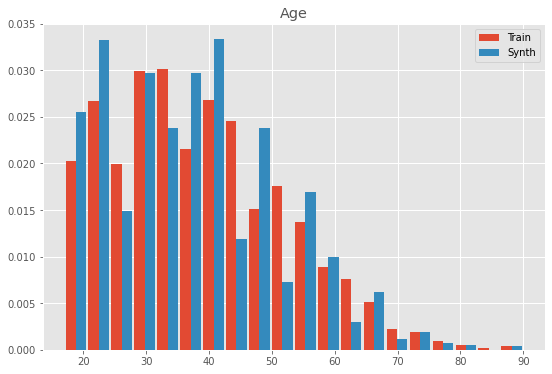

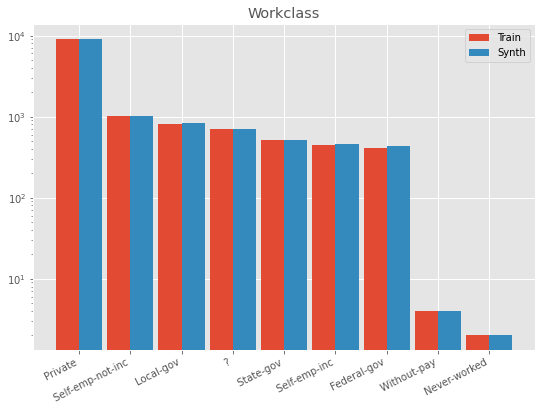

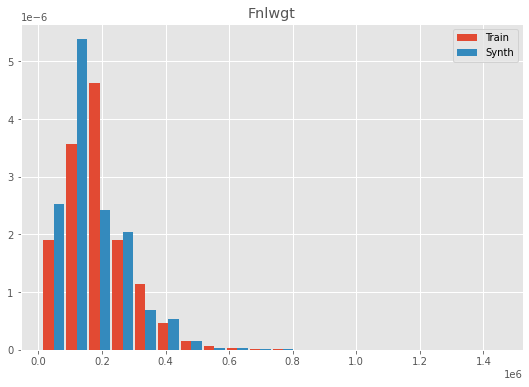

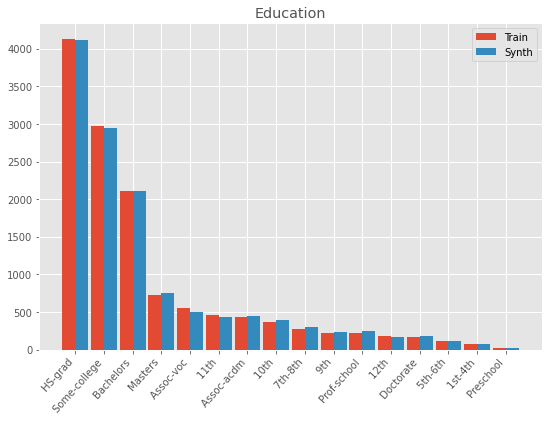

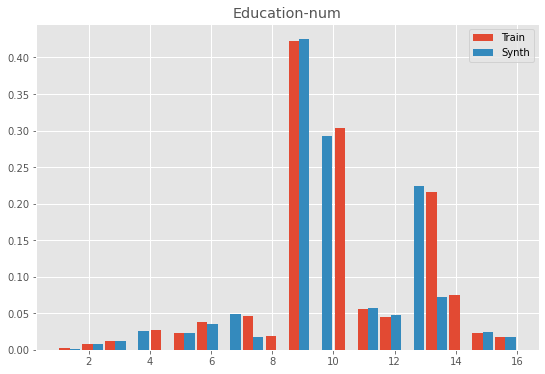

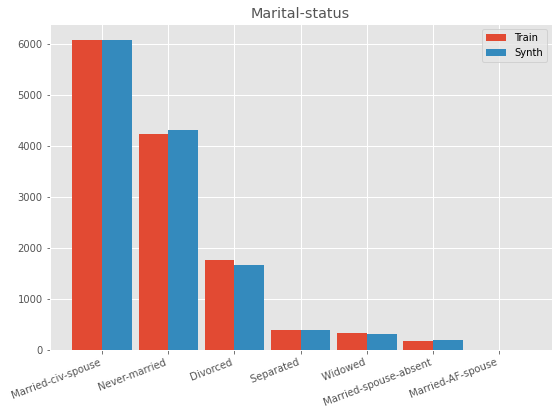

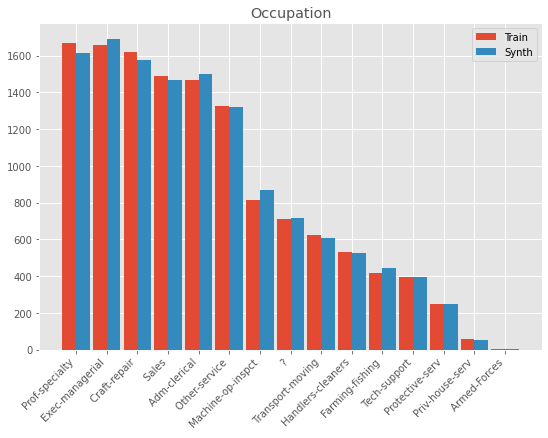

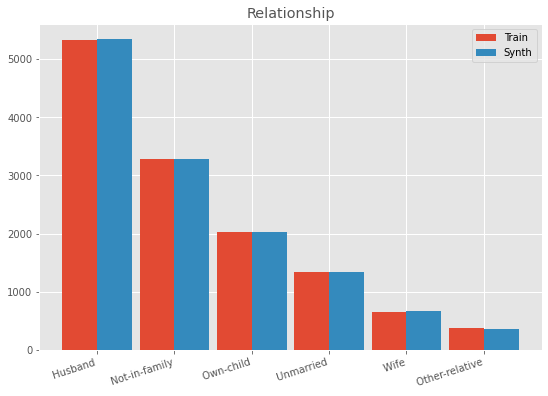

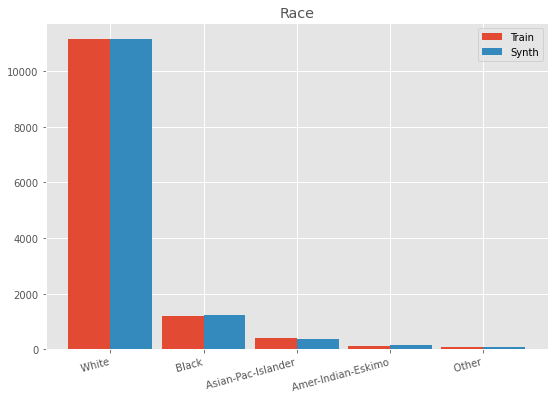

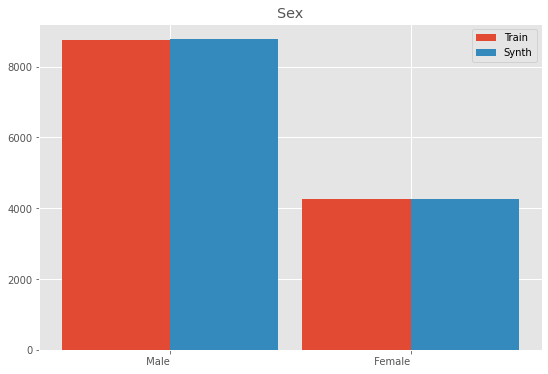

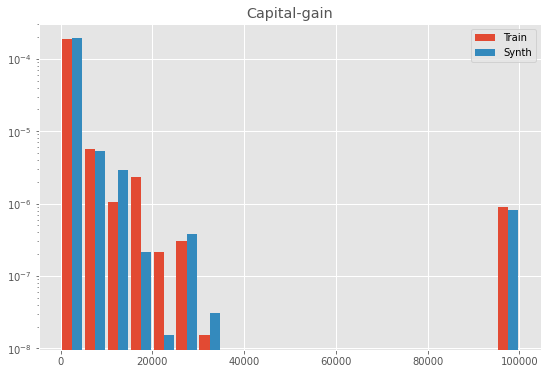

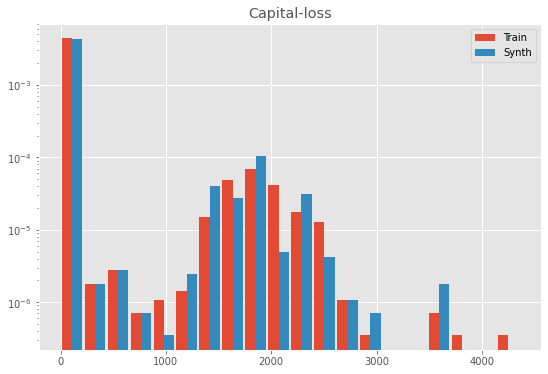

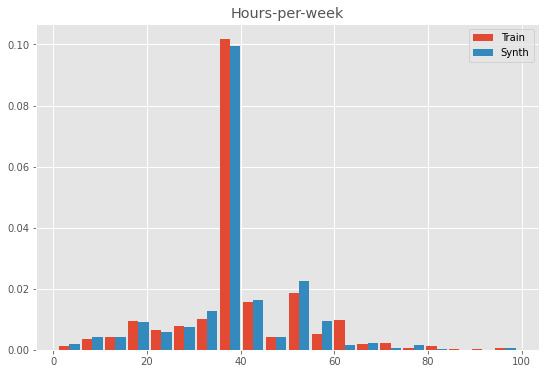

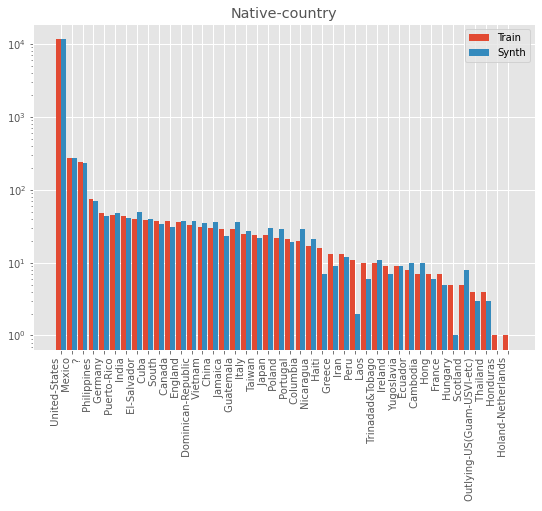

In [ ]:
for col in meta.cols:
    fig, ax = plt.subplots()

    if meta[col].is_cat():
        c_wrk = wrk.value_counts(col)
        c_alg = alg.value_counts(col)
        c = pd.concat([c_wrk, c_alg], axis=1)
        c_wrk, c_alg = c.iloc[:, 0], c.iloc[:, 1]
        keys = list(c_wrk.keys())
        ax.bar(keys, list(c_wrk.values), width=-.45, align="edge", label="Train")
        ax.bar(keys, list(c_alg.values), width=.45, align="edge", label="Synth")
        rot = min(3*len(keys), 90)
        rot = rot if rot > 10 else 0
        plt.setp(ax.get_xticklabels(), rotation=rot, horizontalalignment='right')
        # ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
        # ax.yaxis.set_minor_locator(ticker.MultipleLocator(25000))
        # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '%dk' % (x / 1000) if x else '0'))
        # ax.set_ylim([0, 225000])
    else:
        col_bins = np.histogram_bin_edges(wrk[col], bins=20).astype(np.float32)
        ax.hist([wrk[col], alg[col]], bins=col_bins, density=True, rwidth=0.9, label=["Train", "Synth"])
        # ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
        if meta[col].metrics.x_log:
            ax.set_xscale('log') 
    
    metrics = meta[col].metrics

    if metrics.y_log:
        ax.set_yscale('log')
    ax.set_title(col.capitalize())
    ax.set_xlim([metrics.x_min, metrics.x_max])
    ax.set_ylim([metrics.y_min, metrics.y_max])
    ax.legend()
    


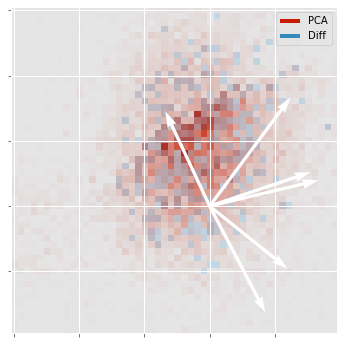

In [ ]:
from sklearn.decomposition import PCA

numerical = [name for name, c in meta.cols.items() if c.type == "numerical"]

n_wrk = wrk[numerical]
n_alg = alg[numerical]

std = np.std(n_wrk, axis=0)
mean = np.std(n_alg, axis=0)

n_wrk = (n_wrk - mean) / std
n_alg = (n_alg - mean) / std

pca = PCA(2, random_state=random_state)
pca.fit(n_wrk)
pca_wrk = pca.transform(n_wrk)
pca_alg = pca.transform(n_alg)

lims = np.percentile(pca_wrk, [3, 97], axis=0) 

def f_lims(data, buffer=0.1):
    l_min, l_max = data
    l_dev = l_max - l_min
    return l_min - buffer*l_dev, l_max + buffer*l_dev

x_min, x_max = f_lims(lims[:, 0])
y_min, y_max = f_lims(lims[:, 1])

bins = 50
H_wrk, xedges, yedges = np.histogram2d(pca_wrk[:, 0], pca_wrk[:, 1], range=[[x_min, x_max], [y_min, y_max]], bins=bins)
H_alg, _, _ = np.histogram2d(pca_alg[:, 0], pca_alg[:, 1], bins=[xedges, yedges])

h_diff = np.abs(H_wrk - H_alg)
h_diff /= np.max(H_alg)
h_wrk = H_wrk / np.max(H_wrk)
h_alg = H_alg / np.max(H_alg)

width, height = H_wrk.shape
img_wrk = np.zeros((width, height, 4), dtype="int32")
img_alg = np.zeros((width, height, 4), dtype="int32")
img_dff = np.zeros((width, height, 4), dtype="int32")

for i in range(width):
    for j in range(height):
        img_wrk[i, j, :] = (255*np.array((0.78, 0.11, 0.008, h_wrk[i,j]))).astype('int32')
        img_alg[i, j, :] = (255*np.array((0.78, 0.11, 0.008, h_alg[i,j]))).astype('int32')
        img_dff[i, j, :] = (255*np.array((0.008, 0.58, 0.933, 0.15 if h_diff[i,j] > 0.1 else 0))).astype('int32')

fig, ax = plt.subplots()
ax.imshow(img_alg, interpolation="nearest")
ax.imshow(img_dff, interpolation="nearest")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#c71c02", lw=4),
                Line2D([0], [0], color="#348abd", lw=4)]

ax.legend(custom_lines, ['PCA', "Diff"])
ax.set_xticklabels([])
ax.set_yticklabels([])

width, length = img_wrk.shape[:2]

comp = pca.components_ / np.expand_dims(np.max(np.abs(pca.components_), axis=1), axis=1)
x = [3/5*width for _ in range(len(comp[0]))]
y = [3/5*length for _ in range(len(comp[0]))]
ax.quiver(x, y, comp[0, :], comp[1, :], scale=3, width=0.01, color="white");

# fig, ax = plt.subplots()
# ax.imshow(img_wrk, interpolation="nearest")
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# fig, ax = plt.subplots()
# ax.imshow(img_alg, interpolation="nearest")
# ax.set_xticklabels([])
# ax.set_yticklabels([]);

# l_num = 5
# x_pos = np.linspace(0, img.shape[0], l_num+2)[1:-1]
# x_labels = np.linspace(x_min, x_max, l_num+2)[1:-1].astype('int32')
# ax.set_xticks(x_pos, x_labels)

# y_pos = np.linspace(0, img.shape[0], l_num+2)[1:-1]
# y_labels = np.linspace(y_min, y_max, l_num+2)[1:-1].astype('int32')
# ax.set_yticks(y_pos, y_labels)
# ax.grid(False)

In [ ]:
np.max(np.abs(pca.components_), axis=1)

array([0.54545502, 0.55842739])